In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Load the dataset
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')


In [2]:
# Content-based filtering function
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [4]:
# Collaborative filtering function- SVD from Suprise
reader = Reader(line_format='user item rating timestamp', sep='::')
data = Dataset.load_from_file('../ml-1m/ratings.dat', reader=reader)
trainset, testset = train_test_split(data, test_size=0.2) # 80% train, 20% test

algo = SVD()
algo.fit(trainset)

In [5]:
# Function to get movie recommendations
def hybrid_recommend(user_id, title, top_n=10, alpha=0.5): # alpha is the weight for content-based filtering
    # content based similarity scores
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    movie_indices = [i[0] for i in sim_scores[1:top_n+1]] # exclude the first one as it is the movie itself

    # COmbine with collaborative predictions
    hybrid_scores = []
    for movie_idx in movie_indices:
        movie_id = movies.iloc[movie_idx]['movieId']
        cb_score = sim_scores[movie_idx][1]
        try:
            cf_score = algo.predict(user_id, movie_id).est / 5.0 # Normalize the SVD score to [0, 1]
        except:
            cf_score = 0.0
        hybrid_score = alpha * cb_score + (1 - alpha) * cf_score
        hybrid_scores.append((movie_idx, hybrid_score))
    
    # Top N recommendations
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    top_movies = [i[0] for i in hybrid_scores[:top_n]]

    return movies.iloc[top_movies][['title', 'genres']]

In [6]:
# Plotting the recommendations

import matplotlib.pyplot as plt

def show_recomendations(df, title):
    type(df)  # Ensure df is a DataFrame
    plt.figure(figsize=(8, 5))
    plt.barh(df['title'], [1]*len(df), color='skyblue') # dummy values for bar height
    plt.title(f"Top Recommendations for '{title}'")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest recommendation on top
    plt.xlabel('Similarity Score')
    plt.tight_layout()
    plt.show()

In [7]:
# Example usage
user_id = 1  # Example user ID
title = 'Toy Story (1995)'  # Example movie title
recommendations = hybrid_recommend(user_id, title, top_n=10, alpha=0.5)
print(recommendations)

                                               title  \
12                                      Balto (1995)   
1050          Aladdin and the King of Thieves (1996)   
2072                        American Tail, An (1986)   
2073      American Tail: Fievel Goes West, An (1991)   
2285                       Rugrats Movie, The (1998)   
2286                            Bug's Life, A (1998)   
3045                              Toy Story 2 (1999)   
3542                           Saludos Amigos (1943)   
3682                              Chicken Run (2000)   
3685  Adventures of Rocky and Bullwinkle, The (2000)   

                           genres  
12           Animation|Children's  
1050  Animation|Children's|Comedy  
2072  Animation|Children's|Comedy  
2073  Animation|Children's|Comedy  
2285  Animation|Children's|Comedy  
2286  Animation|Children's|Comedy  
3045  Animation|Children's|Comedy  
3542  Animation|Children's|Comedy  
3682  Animation|Children's|Comedy  
3685  Animation|Childre

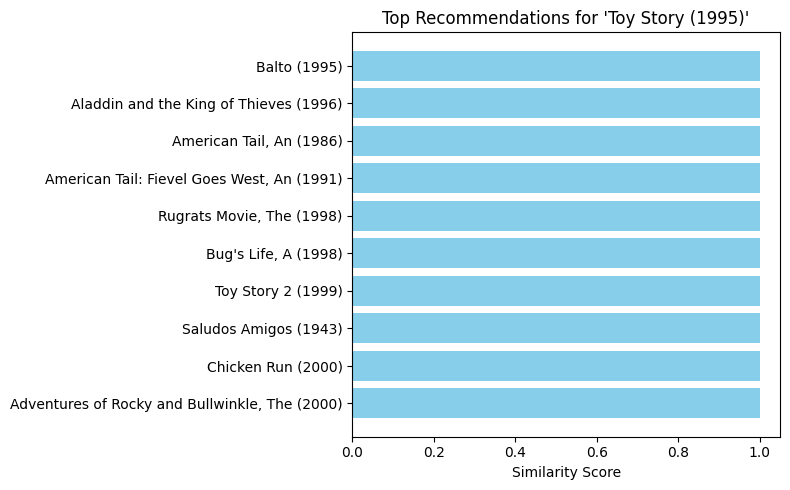

In [9]:
show_recomendations(recommendations, title)